# Disclaimer
### **This notebook is made for reaserch purposeses and should not be taken as an advice for any financial action!

In this project we want to predict Tesla's stock price using 3 different learning objectives, Lstm, Arima and Prophet.


## Data

In [1]:
import pandas as pd
from stock_prediction.yfinance_data import StockData
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import MeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
tsla = StockData(symbol='TSLA', start_date="2016-01-01", end_date="2021-01-01")
data = tsla.get_historical_symbol_data().reset_index()
data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Adj Close,Open,High,Low,Close,Volume
0,2016-01-04,14.89,15.38,15.43,14.60,14.89,102406500
1,2016-01-05,14.90,15.09,15.13,14.67,14.90,47802000
2,2016-01-06,14.60,14.67,14.67,14.40,14.60,56686500
3,2016-01-07,14.38,14.28,14.56,14.24,14.38,53314500
4,2016-01-08,14.07,14.52,14.70,14.05,14.07,54421500


In [3]:
data.shape

(1259, 7)

In [4]:
data.describe()

,Date,Adj Close,Open,High,Low,Close,Volume
count,1259,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,2018-07-03 08:18:40.889594880,34.269301,34.205115,35.001414,33.382796,34.269301,1.314455e+08
min,2016-01-04 00:00:00,9.580000,9.490000,10.330000,9.400000,9.580000,2.489250e+07
25%,2017-04-03 12:00:00,15.845000,15.760000,16.030000,15.505000,15.845000,7.167825e+07
50%,2018-07-03 00:00:00,20.580000,20.500000,20.920000,20.130000,20.580000,1.034160e+08
75%,2019-10-02 12:00:00,23.840000,23.870000,24.315000,23.475000,23.840000,1.561389e+08
max,2020-12-31 00:00:00,235.220000,233.330000,239.570000,230.370000,235.220000,9.140820e+08
std,NaN,40.340924,40.126049,41.258761,38.948001,40.340924,9.227598e+07


### As we can see the price has significantly risen over the past few years
### Our first learning objective will be Arima Model, so lets see if this method could be be

In [5]:
data.shape

(1259, 7)

In [6]:
data.describe()

,Date,Adj Close,Open,High,Low,Close,Volume
count,1259,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,2018-07-03 08:18:40.889594880,34.269301,34.205115,35.001414,33.382796,34.269301,1.314455e+08
min,2016-01-04 00:00:00,9.580000,9.490000,10.330000,9.400000,9.580000,2.489250e+07
25%,2017-04-03 12:00:00,15.845000,15.760000,16.030000,15.505000,15.845000,7.167825e+07
50%,2018-07-03 00:00:00,20.580000,20.500000,20.920000,20.130000,20.580000,1.034160e+08
75%,2019-10-02 12:00:00,23.840000,23.870000,24.315000,23.475000,23.840000,1.561389e+08
max,2020-12-31 00:00:00,235.220000,233.330000,239.570000,230.370000,235.220000,9.140820e+08
std,NaN,40.340924,40.126049,41.258761,38.948001,40.340924,9.227598e+07


### As we can see the price has significantly risen over the past few years
### Our first learning objective will be Arima Model, so lets see if this method could be be some Autocorrelation in our data

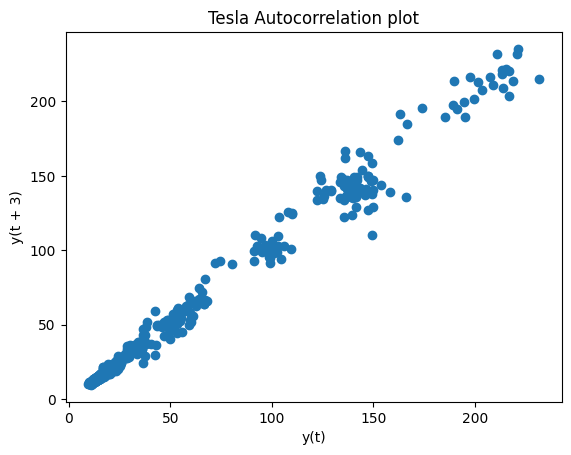

In [7]:
plt.figure()
lag_plot(data['Close'], lag=3)
plt.title('Tesla Autocorrelation plot')
plt.show()

### Looks like our data has a strong correlation between the close price as time 't+3' to its past close price at time 't' 
### Thats a good news for our Arima model

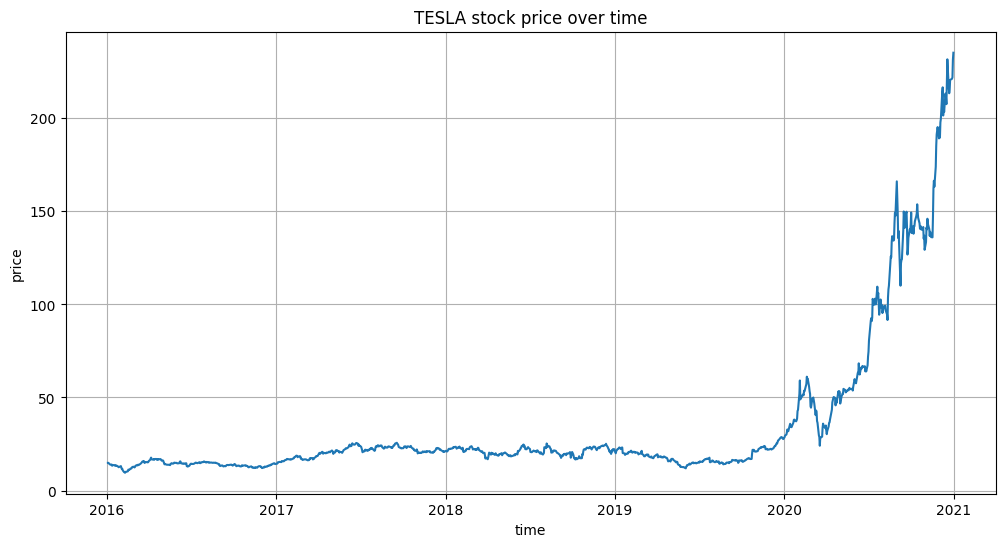

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Close"])
plt.title("TESLA stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.grid()
plt.show()

# Arima Model Trainning

In [9]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data['Close'].to_frame()

In [10]:
data

,Close
Date,
2016-01-04,14.89
2016-01-05,14.90
2016-01-06,14.60
2016-01-07,14.38
2016-01-08,14.07
...,...
2020-12-24,220.59
2020-12-28,221.23
2020-12-29,222.00


In [11]:
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = data.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [12]:
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)

In [13]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error (MSE): 28.931679365079365
Mean Absolute Error (MAE): 3.637301587301587
R2 Score: 0.9908294973497879


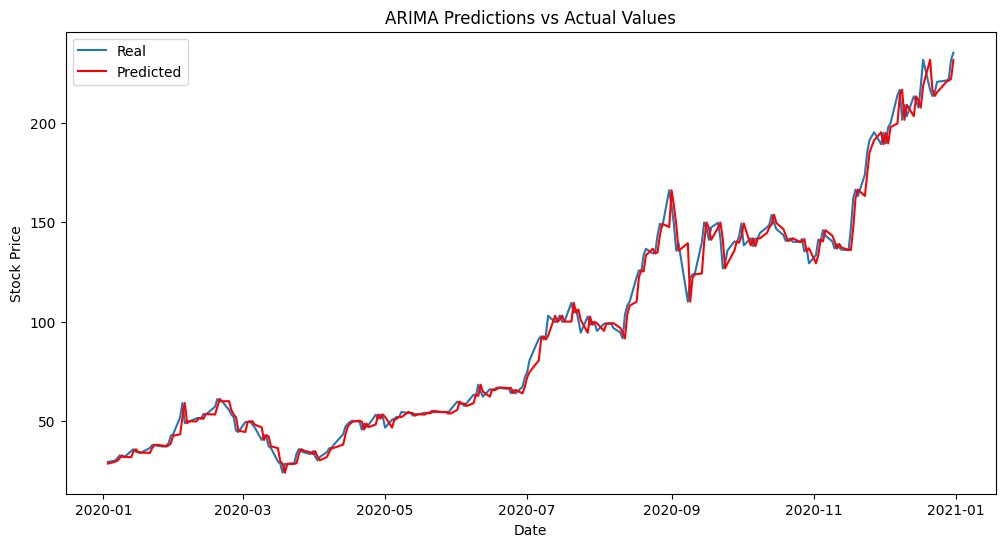

In [14]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(data.iloc[size:,:].index, test, label='Real')
plt.plot(data.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Learning Objective 2: LSTM

In [ ]:
tsla = StockData(symbol='TSLA', start_date="2020-01-01", end_date="2024-01-01")
data = tsla.get_historical_symbol_data()
data.head()


In [ ]:
def ts_train_test_normalize(all_data,time_steps,for_periods):

    # create training and test set
    ts_train = all_data[:'2022'].iloc[:,0:1].values
    ts_test  = all_data['2023':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2022'], all_data["Adj Close"]['2023':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [ ]:
X_train, y_train, X_test, sc = ts_train_test_normalize(data,5,2)

In [ ]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = data.loc['2023':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )

In [31]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = data.loc['2023':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )

5/5 [==============================] - 0s 1ms/step


(149.65277, <Axes: xlabel='Date'>)

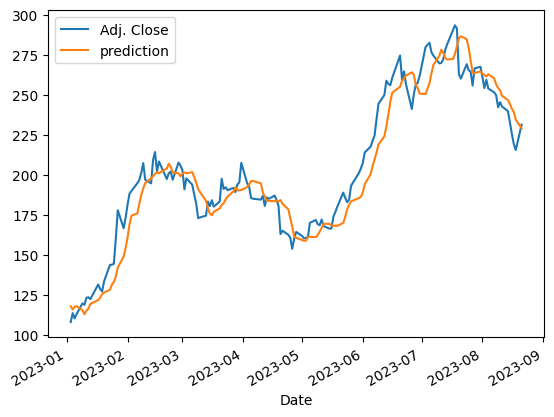

In [32]:

def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='adam',loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)   